# Phase 4 Testing
**Purpose:** Evaluate Phase 3 features on a larger dataset, visualise feature importance and SHAP explanations, inspect predictions and residuals.

In [1]:
# Imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from src.preprocess import preprocess
from src.feature_engineering import expand_features_fast as expand_features
from src.train_model import train_random_forest

In [2]:
# Load and preprocess dataset
df = preprocess(
    "/data/tmdb_movie_dataset.csv",
    nrows=20000  # smaller subset for speed
)
print("✅ Dataset loaded and preprocessed:", df.shape)

✅ Dataset loaded and preprocessed: (9607, 31)


In [3]:
# Expand features
df, new_features = expand_features(df)  # no extra arguments needed
print(f"✅ Features generated: {len(new_features)}")

# Base features
base_features = [
    'vote_average', 'vote_count', 'runtime', 'release_year',
    'release_month', 'release_quarter', 'release_season',
    'log_runtime', 'weighted_vote'
]
feature_cols = base_features + new_features
print(f"✅ Total features used: {len(feature_cols)}")

✅ Features generated: 50
✅ Total features used: 59


In [4]:
# Train RandomForest
print("Training RandomForest...")
model, X, y, mse_mean, mse_std, r2_mean, r2_std = train_random_forest(df, feature_cols)
print(f"RandomForest - MSE: {mse_mean:.2f} ± {mse_std:.2f}, R²: {r2_mean:.2f} ± {r2_std:.2f}")

Training RandomForest...
RandomForest - MSE: 4.75 ± 0.84, R²: -0.27 ± 0.57


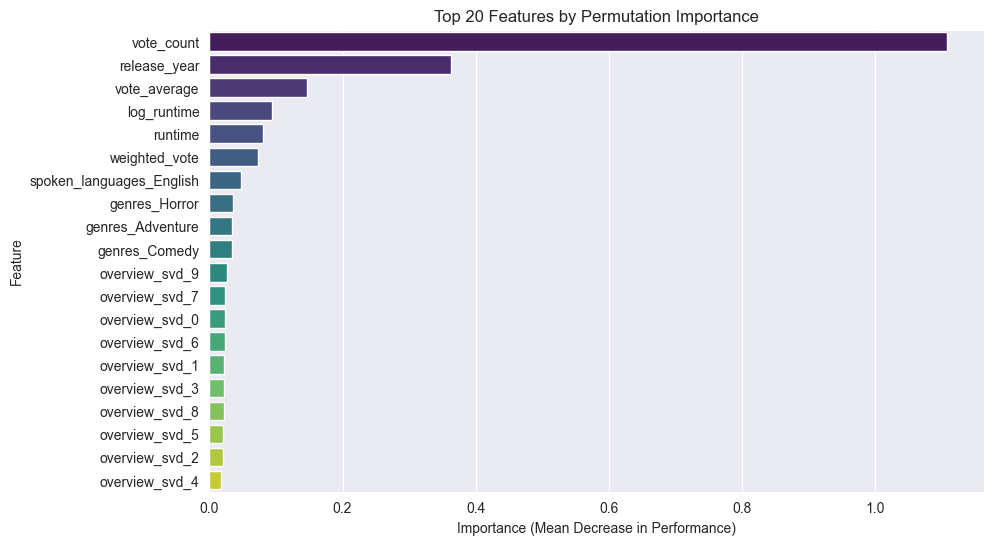

In [5]:
# Permutation feature importance
perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[::-1]

top_n = 20
top_features = [X.columns[i] for i in sorted_idx[:top_n]]
top_scores = [perm_importance.importances_mean[i] for i in sorted_idx[:top_n]]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_scores, y=top_features, palette="viridis")
plt.title("Top 20 Features by Permutation Importance")
plt.xlabel("Importance (Mean Decrease in Performance)")
plt.ylabel("Feature")
plt.show()

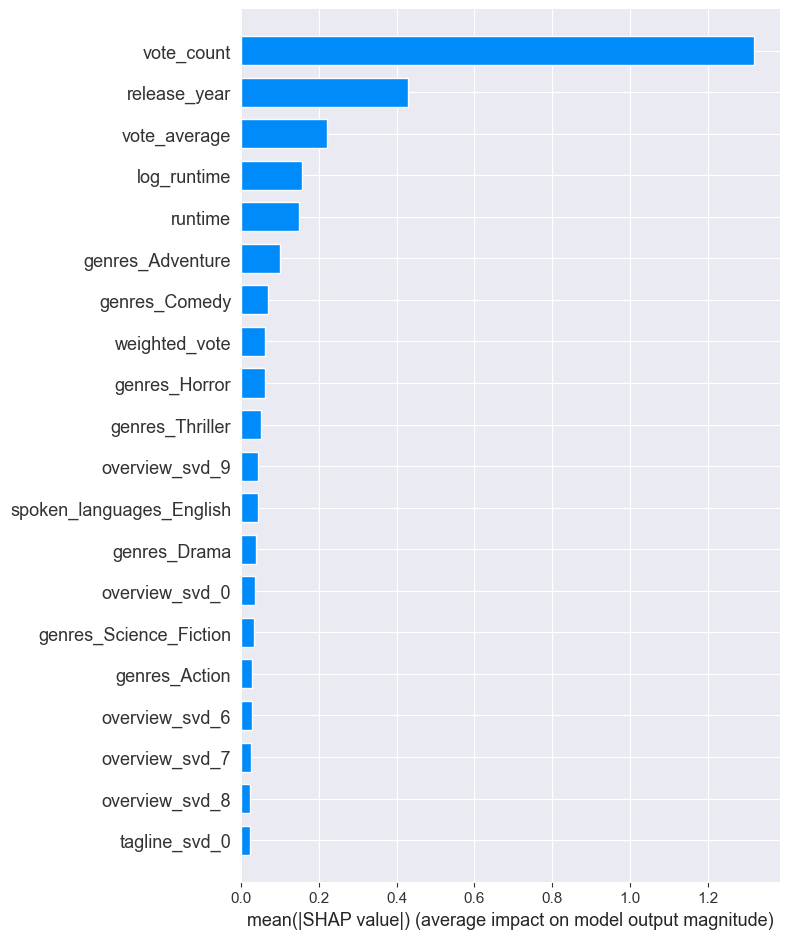

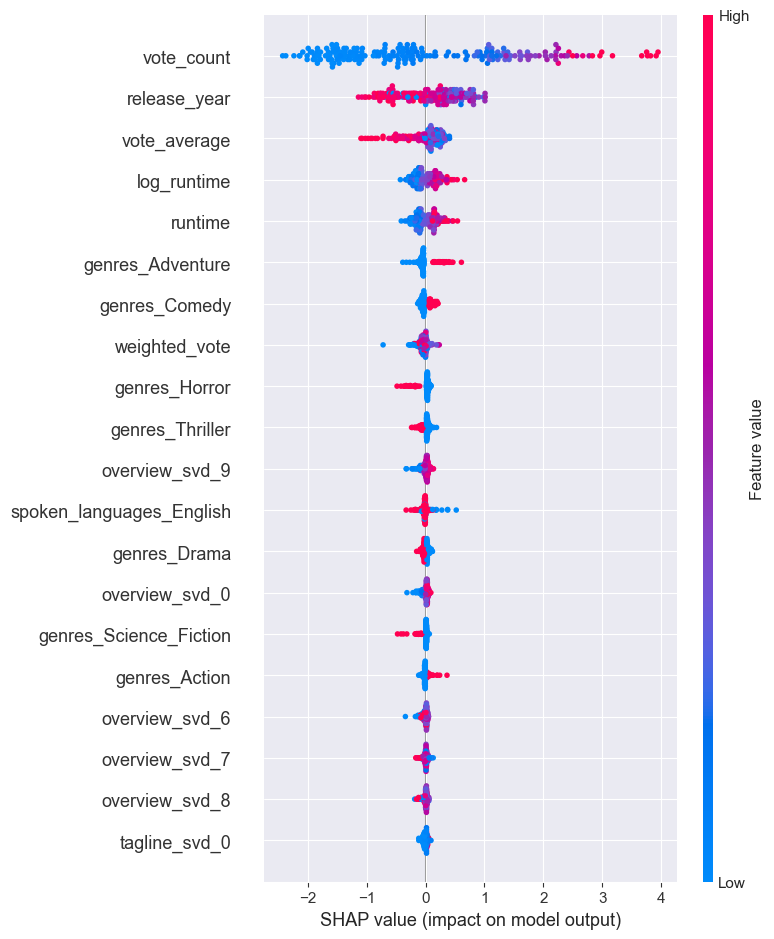

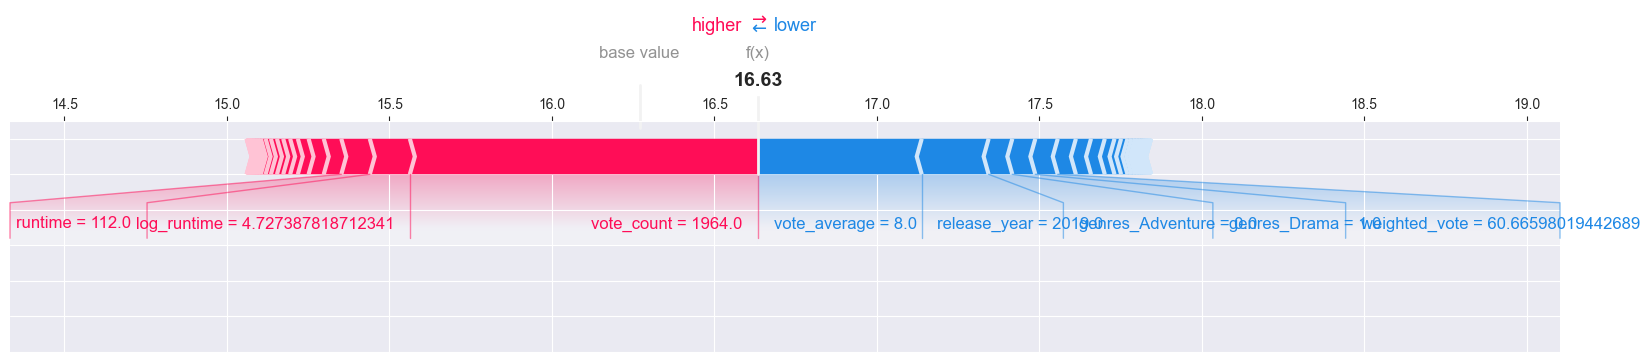

In [12]:
# SHAP explanations
# Sample rows only (keep all features)
X_sample = X.sample(200, random_state=42)

# TreeExplainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Global summary (bar)
shap.summary_plot(shap_values, X_sample, plot_type="bar", max_display=20)

# Dot summary
shap.summary_plot(shap_values, X_sample, max_display=20)

# Force plot for a single sample
shap.force_plot(
    explainer.expected_value,
    shap_values[0, :],
    X_sample.iloc[0, :],
    matplotlib=True
)

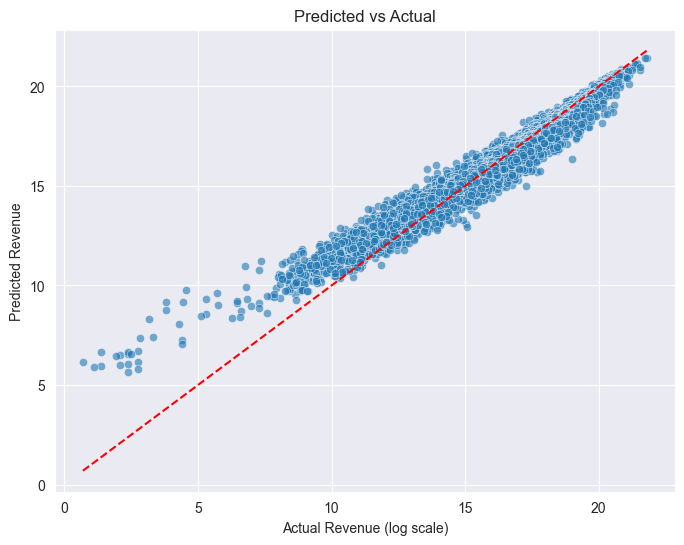

In [6]:
# Predicted vs Actual (matplotlib)
y_pred = model.predict(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y, y=y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Revenue (log scale)")
plt.ylabel("Predicted Revenue")
plt.title("Predicted vs Actual")
plt.show()

In [7]:
# Predicted vs Actual (interactive Plotly)
fig = px.scatter(x=y, y=y_pred, opacity=0.6,
                 labels={'x': 'Actual Revenue (log scale)', 'y': 'Predicted Revenue'},
                 title="Predicted vs Actual (Interactive)")
fig.add_trace(go.Scatter(x=[y.min(), y.max()], y=[y.min(), y.max()],
                         mode="lines", line=dict(color="red", dash="dash"), name="Ideal Fit"))
fig.show()

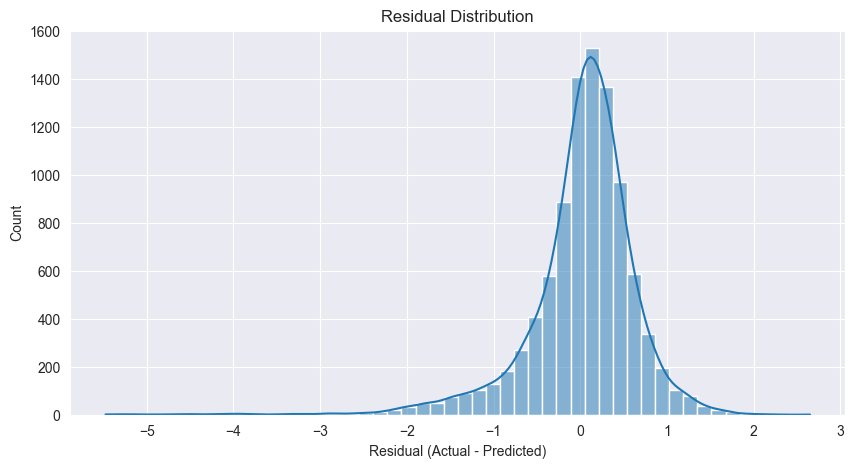

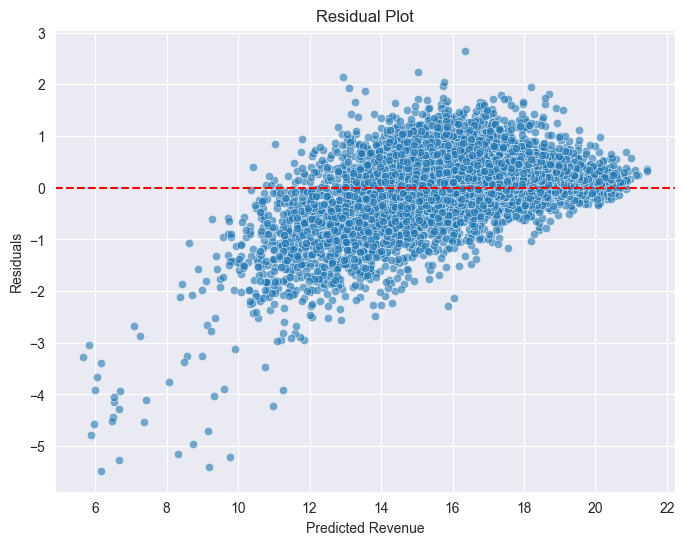

In [8]:
# Residual Analysis
residuals = y - y_pred

plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Revenue")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [9]:
# Train-test split evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)

comparison = pd.DataFrame({
    "Actual Revenue": y_test[:10].values,
    "Predicted Revenue": y_pred_test[:10]
}).reset_index(drop=True)
print("\nSample Predictions vs Actuals:")
display(comparison)


Sample Predictions vs Actuals:


,Actual Revenue,Predicted Revenue
0,19.046434,16.633889
1,15.607270,15.127313
2,13.341992,13.300447
3,15.519704,15.620635
4,13.634538,14.314432
5,18.463660,18.217774
6,15.230489,14.609808
7,15.969453,17.802095
8,18.919321,18.336900
9,16.785736,16.523656


In [ ]:
print("📊 Insights Summary")
print("- Feature importance highlights drivers of revenue.")
print("- SHAP values show how each feature impacts predictions.")
print("- Predicted vs Actual plots demonstrate fit quality.")
print("- Residual plots help diagnose errors and bias.")
print("- Plotly adds interactivity for CV-friendly storytelling.")